# Submission to the ArangoDB Hackathon
## By Patrick Wendo & Sam Chris Kombo

The dataset used in this notebook is available on [Kaggle](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

However, we do a lot of data manipulation in order to load it into a graph. 

The dataset used contains information about anime shows obtained. It also contains information about Manga, but we do not use that yet. 

The data is: 
> complete, cleaned and weekly updated MyAnimeList Anime and Manga datasets, containing 24,165 Animes and 67,273 Mangas, last updated on 7th August 2023.

The anime data is split into a number of data frames that are all loaded into the graph. The beauty of graph data is that it does for the most part not require a schema. This gives us leeway to play around with data representation.



In [76]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy python-dotenv scikit-learn
!pip3 install --upgrade langchain langchain-community langchain-openai langgraph gradio

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Using this notebook.

1. You need to define a `.env` file with 2 entries. 
    i. `SAMBANOVA_KEY` - We use sambanova to use as our LLM provider. This allows us to change which LLM we are using on the fly be it *DeepSeek-R1, Meta-Llama or Qwen*
    ii. `ARANGO_DB_PASS` - This is the password for ARANGODB. 
2. If you are using arangoDB cloud, you will need to also add entries for the `ARANGODB_ENDPOINT` and `ARANGODB_USER` in the `.env`
3. Ensure You have python 3.10 installed.

In [77]:
from arango import ArangoClient
from dotenv import load_dotenv

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re
import os
import openai

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

sambanova_key = os.getenv("SAMBANOVA_KEY")

db = ArangoClient(hosts="http://localhost:8529").db("hackathon", username="root", password=os.getenv("ARANGO_DB_PASS"), verify=True)

# Uncomment if you are using arango cloud. Ensure you have updated the .env file accordingly. 
# db = ArangoClient(hosts=os.getenv("ARANGODB_ENDPOINT")).db(os.getenv("DATABASENAME"), username=os.getenv("ARANGODB_USER"), password=os.getenv("ARANGO_DB_PASS"), verify=True)

print(db)

# For testing, we use a subset of the dataset for quick iterations.
# Comment this to not load the subset dataset.
anime = pd.read_csv(
    "./datasets/myanimelist/anime_subset.csv"
)

# Uncomment this to load the full dataset
# anime = pd.read_csv(
#     "./datasets/myanimelist/anime.csv"
# )

anime.head()


<StandardDatabase hackathon>


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']


In [78]:
anime

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']
5,32281,Kimi no Na wa.,movie,8.84,1825476,finished_airing,1,2016-08-26,2016-08-26,original,...,"['Toho', 'Sound Team Don Juan', 'Amuse', 'JR E...","['Funimation', 'NYAV Post']","Mitsuha Miyamizu, a high school girl, yearns t...",Kimi no Na wa. won the LAFCA Animation Award i...,https://cdn.myanimelist.net/images/anime/5/870...,https://myanimelist.net/anime/32281/Kimi_no_Na_wa,https://www.youtube.com/watch?v=3KR8_igDs1Y,Your Name.,君の名は。,[]
6,2904,Code Geass: Hangyaku no Lelouch R2,tv,8.91,1154270,finished_airing,25,2008-04-06,2008-09-28,original,...,"['Bandai Visual', 'Mainichi Broadcasting Syste...","['Funimation', 'Bandai Entertainment']","One year has passed since the Black Rebellion,...",Code Geass: Hangyaku no Lelouch R2 is an origi...,https://cdn.myanimelist.net/images/anime/1088/...,https://myanimelist.net/anime/2904/Code_Geass_...,NaN,Code Geass: Lelouch of the Rebellion R2,コードギアス 反逆のルルーシュ 続編,"['Code Geass: Hangyaku no Lelouch 2nd Season',..."
7,40028,Shingeki no Kyojin: The Final Season,tv,8.80,1237778,finished_airing,16,2020-12-07,2021-03-29,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Gabi Braun and Falco Grice have been training ...,Shingeki no Kyojin: The Final Season adapts co...,https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"['Shingeki no Kyojin Season 4', 'Attack on Tit..."


## DATA EXPLORATION

- We have an anime dataset 
- It is a relational dataset with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- When dealing with edges, we could also have attributed edges. The simplest example, would be if you represent a road network as a graph, the distance, between the nodes could be an attribute of an edge. Typically, we consider this a weight. 

- The node label would be the name of the anime. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly, for columns like studios, themes, producers, licensors and demographics.

In [79]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

### Data Fix #1 :: Sanitization
- Because the anime, will use an ID of some kind, we update the anime title to be prefixed with its anime_id. For instance;
    ```
    {
        anime_id: 5114,
        title: "fullmetal alchemist: Brotherhood"
    }
    ```
    - Should become: anime_id: `5114_fullmetal_alchemist_brotherhood`
- Further, the ID should not have any characters that are disallowed by arangoDB, like whitespace, slashes, backslashes, dots at the beginning, colons, asterisks, question marks, exclamation marks, plus signs, percent signs, ampersands or equal signs, so we perform a search and replace for the new fields. 

In [80]:
def sanitize_text(text):
    """Replace spaces with underscores and remove invalid characters."""
    text = re.sub(r'\s+', '_', text)  # Replace spaces with underscores
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    return text

def update_anime_id(anime_df):
    """Update anime_id by concatenating it with title, then sanitize."""
    anime_df["anime_id"] = anime_df["anime_id"].astype(str) + "_" + anime_df["title"]
    anime_df["anime_id"] = anime_df["anime_id"].apply(sanitize_text)
    
    return anime_df


anime = update_anime_id(anime)
anime.head(1)


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.1,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...


### Data fix #2 :: Indexing for ArangoDB

- ArangoDB requires a field with the key `_key` to function as the key for a node. 
- Any value that will become a node should have this key. 


In [81]:
def add_key_column(dataframe, id_column):
    dataframe['_key'] = dataframe[id_column]
    return dataframe

anime = add_key_column(anime, "anime_id")
anime

,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148,2011-10-02,2014-09-24,manga,...,['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10,2019-04-29,2019-07-01,manga,...,['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,1348232,finished_airing,24,2011-04-06,2011-09-14,visual_novel,...,['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
4,28851_Koe_no_Katachi,Koe no Katachi,movie,8.94,1540277,finished_airing,1,2016-09-17,2016-09-17,manga,...,"['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,[The Shape of Voice],28851_Koe_no_Katachi
5,32281_Kimi_no_Na_wa.,Kimi no Na wa.,movie,8.84,1825476,finished_airing,1,2016-08-26,2016-08-26,original,...,"['Funimation', 'NYAV Post']","Mitsuha Miyamizu, a high school girl, yearns t...",Kimi no Na wa. won the LAFCA Animation Award i...,https://cdn.myanimelist.net/images/anime/5/870...,https://myanimelist.net/anime/32281/Kimi_no_Na_wa,https://www.youtube.com/watch?v=3KR8_igDs1Y,Your Name.,君の名は。,[],32281_Kimi_no_Na_wa.
6,2904_Code_Geass_Hangyaku_no_Lelouch_R2,Code Geass: Hangyaku no Lelouch R2,tv,8.91,1154270,finished_airing,25,2008-04-06,2008-09-28,original,...,"['Funimation', 'Bandai Entertainment']","One year has passed since the Black Rebellion,...",Code Geass: Hangyaku no Lelouch R2 is an origi...,https://cdn.myanimelist.net/images/anime/1088/...,https://myanimelist.net/anime/2904/Code_Geass_...,NaN,Code Geass: Lelouch of the Rebellion R2,コードギアス 反逆のルルーシュ 続編,"[Code Geass: Hangyaku no Lelouch 2nd Season, C...",2904_Code_Geass_Hangyaku_no_Lelouch_R2
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,1237778,finished_airing,16,2020-12-07,2021-03-29,manga,...,['Funimation'],Gabi Braun and Falco Grice have been training ...,Shingeki no Kyojin: The Final Season adapts co...,https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Se

### Data Fix #3 :: Data Separation.
- We want specific columns to become individual dataframes. For instance, `"genres"`, `"themes"`, `"demographics"` and `"studios"` should be their own dataframes because each value in those dataframe will be their own nodes.
- Further, these columns also carry lists as their entries. We use the `#explode()` method to split this lists into single entries. 
- At the end of this, we end up with 4 new dataframes, one for `genres, themes, demographics` and `studios`

In [82]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

def fix_keys(df):
    df["_key"] = df["_key"].astype(str).replace("-", "_", regex=True)
    df["_key"] = df["_key"].astype(str).replace(" ", "_", regex=True)
    return df

def build_new_dataframe(dataframe, column):
    new_explode = anime.explode(column)
    new_dataframe = new_explode.groupby(column)
    new_dataframe = new_dataframe.groups.keys()
    new_dataframe = pd.DataFrame(new_dataframe, columns=[column]).reset_index()
    new_dataframe = add_key_column(new_dataframe, column)
    new_dataframe = fix_keys(new_dataframe)
    new_dataframe = new_dataframe[[column, "_key"]]
    new_dataframe["type"] = column
    return new_dataframe


genre_dataframe = build_new_dataframe(anime, "genres")
demographics_dataframe = build_new_dataframe(anime, "demographics")
studios_dataframe = build_new_dataframe(anime, "studios")
themes_dataframe = build_new_dataframe(anime, "themes")

### Data Fix #4 :: Removing data we don't necessarily use. 
- My teachers always told me to `never throw away data`, so this step is entirely optional for the person running this notebook. 
- Removing unused attributes from the anime dataset. 
- Some columns in the dataset will not be used in defining the attributes for the anime dataset. We filter these out. 

In [83]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "_key": "_key",
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "studios": "studios",
    "themes": "themes",
    "demographics": "demographics",
    "genres": "genres",
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms",
    "members": "members"
}

# (node_attributes.values())
anime = anime[anime.columns.intersection(list(node_attributes.values()))]

### Data Fix 5 :: Remove the NaN
- We drop the NaN columns. These caused us so much pain initially before we realised that they are the problem. 
- They do majorly reduce the size of the dataset when you use the entire anime dataset.

In [84]:
anime.dropna(inplace=True)
anime

/tmp/ipykernel_81297/1893779218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime.dropna(inplace=True)


,anime_id,title,type,score,status,source,members,episode_duration,total_duration,sfw,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,finished_airing,manga,3206028,0 days 00:24:20,1 days 01:57:20,True,...,[Military],[Shounen],[Bones],https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,finished_airing,manga,2688079,0 days 00:23:37,2 days 10:15:16,True,...,[],[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,2133927,0 days 00:23:55,0 days 03:59:10,True,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,2463954,0 days 00:24:20,0 days 09:44:00,True,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,1872476,0 days 00:23:55,0 days 06:22:40,True,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season


### Data fix #6
- Because ArangoDB and NetworkX needs a set of edges, we define an edgelist dataframe that contains only the source key and destination key. 


In [85]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field_1, merge_field_2):
    exploded_df = dataframe1.explode(merge_field_1)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field_1, right_on=merge_field_2)
    edge_list_df = edge_list_df[["_key_x", "_key_y", "type_y"]]
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_dataframe, "demographics", "_key")
genres_edge_list = build_edge_list(anime, genre_dataframe, "genres", "_key")
themes_edge_list = build_edge_list(anime, themes_dataframe, "themes", "_key")
studios_edge_list = build_edge_list(anime, studios_dataframe, "studios", "_key")
demographics_edge_list

,_key_x,_key_y,type_y
0,5114_Fullmetal_Alchemist_Brotherhood,Shounen,demographics
1,11061_Hunter_x_Hunter_(2011),Shounen,demographics
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shounen,demographics
3,40028_Shingeki_no_Kyojin_The_Final_Season,Shounen,demographics


## Data enriching. 

- For some of the data in the new dataframe, we need to add in descriptions. For instance, for the demographic dataframe, we would need to be able to explain/describe what it is. 

#### Enriching Demographics

In [86]:
# 

demographics_descriptions = {
    'Kodomomuke' : 'This type of anime and manga is deliberately made for children below 12 years of age. They are crafted in a way to teach very young audiences about the values and morals of life to become a good person in life',

    'Kids' : 'This type of anime and manga is deliberately made for children below 12 years of age. They are crafted in a way to teach very young audiences about the values and morals of life to become a good person in life',
    
    'Shonen' : 'This type of anime is generally targeted toward teen boys (12-18 years old) but even teen girls like to watch them. he Shonen anime or manga has a central male protagonist (female in rare cases), and it includes a mix of a wide variety of genres such as adventure, action, drama, sci-fi, and more. It includes an adventurous storyline revolving around the protagonist, who aims to achieve his/ her goals bundled with enthralling battles. Also, they are often seen preaching the value of friendship and family.',
    
    'Shounen': 'This type of anime is generally targeted toward teen boys (12-18 years old) but even teen girls like to watch them. he Shonen anime or manga has a central male protagonist (female in rare cases), and it includes a mix of a wide variety of genres such as adventure, action, drama, sci-fi, and more. It includes an adventurous storyline revolving around the protagonist, who aims to achieve his/ her goals bundled with enthralling battles. Also, they are often seen preaching the value of friendship and family.',
    
    'Shojo': 'Shojo is made for young female audiences. It is crafted for young girls, generally between the ages of 12-18. The Shoujo anime or manga explores the feminine side which basically includes genres such as romance and drama. As opposed to Shonen, Shoujo has a female as the lead and the story revolves around her life. The sub-genres of the Shoujo anime type cover Yaoi and Yuri as well, which we will discuss briefly below. ',
    
    'Shoujo': 'Shojo is made for young female audiences. It is crafted for young girls, generally between the ages of 12-18. The Shoujo anime or manga explores the feminine side which basically includes genres such as romance and drama. As opposed to Shonen, Shoujo has a female as the lead and the story revolves around her life. The sub-genres of the Shoujo anime type cover Yaoi and Yuri as well, which we will discuss briefly below. ',

    'Seinen': 'The literal meaning of Seinen is “youth,” and the anime and manga in this category are targeted toward adult men. So, this anime type covers the audience who are 18 and above in age, predominantly males but is also liked by females. Seinen includes all the elements of a typical Shonen anime but elevates it to the next step by having no theme or story restrictions. As there are no restrictions here, Seinen anime includes mature themes, hence, the 18 years and above age requirement. Seinen also covers a wide variety of mature genres, such as psychological, gore, violence, action, erotic, etc., which suit the adult audience better.',

    'Josei' : 'The term Josei refers to “Woman or Female” and is the equivalent of Seinen for females. Thus, Josei is intended for adult women who are 18 and older. Josei is the improved version of Shoujo and shows the realistic lives of women, including their relationships, challenges, and more. Just like Shoujo, Josei also covers LGBTQ+ storylines such as Yaoi and Yuri sub-genres within them',
}

demographics_dataframe["description"] = ''

for key in demographics_descriptions:
    demographics_dataframe.loc[demographics_dataframe['demographics'] == key, "description"] = demographics_descriptions[key]
demographics_dataframe

,demographics,_key,type,description
0,Shounen,Shounen,demographics,This type of anime is generally targeted towar...


#### Enriching Genres
- There are about 20 genres, and we want to have a way to update them if new genres come in. As such, we will attempt to fetch genre descriptions from various online sources.

In [87]:
genre_descriptions = {
    "Action": "The action genre features fast-paced, thrilling, and intense sequences of physical feats, combat, and excitement. The characters of these stories are involved in daring and often dangerous situations, requiring them to rely on their physical prowess, skills, and quick thinking to overcome challenges and adversaries.",

    "Adventure": "The adventure genre features exciting journeys, quests, or expeditions undertaken by characters who often face challenges, obstacles, and risks in pursuit of a goal. Adventures can take place in a wide range of settings, from exotic and fantastical locations to historical or even everyday environments.",

    "Avant Garde": "Experimental fiction which shunned conventional storytelling at the time it was created. These stories often invoke unsettled feelings because they reject traditional ways in which we prefer to view (or escape from) the world. Narrative is avant garde works is often of higher importance than the content. Deconstructions often fall into this genre. Note that simply being darker, edgier, or cynical doesn't mean the work is avant garde",

    "Award Winning" : "Titles which have won prestigious or professional awards in Japan. Examples include the Tokyo Anime Award or Japan Media Arts Festival awards. ",

    "Boys Love": "Depicts homoerotic relationships between male characters. It is typically created by women for a female audience, distinguishing it from the equivalent genre of homoerotic media created by and for gay men, though BL does also attract a male audience and can be produced by male creators.",

    "Comedy": "The comedy genre refers to a category of entertainment that aims to amuse and entertain audiences by using humor, wit, and comedic situations. Comedies are created with the primary intention of eliciting laughter and providing lighthearted enjoyment. They encompass a wide range of styles, tones, and themes, appealing to various tastes and audiences.",

    "Drama": "The drama genre is a broad category that features stories portraying human experiences, emotions, conflicts, and relationships in a realistic and emotionally impactful way. Dramas delve into the complexities of human life, often exploring themes of love, loss, morality, societal issues, personal growth, with the aim to evoke an emotional response from the audience by presenting relatable and thought-provoking stories.",

    "Ecchi": "Ecchi is a slang term in the Japanese language for playfully sexual actions. As an adjective, it is used with the meaning of 'sexy', 'dirty' or 'naughty'; as a verb, ecchi suru means 'to have sex', and as a noun, it is used to describe someone of lascivious behavior. It is softer than the Japanese word ero, and does not imply perversion in the way hentai does. The word ecchi has been adopted by western fans of Japanese media to describe works with sexual overtones. In western culture, it has come to be used to refer to softcore or playful sexuality, as distinct from the word hentai, which connotes perversion or fetishism. ", 

    "Erotica": "Anime hentai refers to a subgenre of Japanese animation that incorporates explicit sexual content. It gained popularity in the late 20th century and continues to be a prominent category within the anime industry.",

    "Fantasy" : "The fantasy genre features imaginative and often magical worlds, characters, and events. It explores realms beyond the boundaries of reality, featuring elements such as magic, mythical creatures, supernatural powers, and fantastical settings. These stories can take place in entirely fictional worlds or blend fantastical elements with real-world settings.",

    "Game": "These anime encompass shows that mainly focus on gaming and playing themes. For instance, anime may include characters playing board games, card games, puzzle games, and virtual online games.",

    "Girls Love": "Same-sex romantic/sexual relationships between women are the focus of these stories. In Japan, the term Yuri is commonly used to refer this media. Girls Love and its abbreviation GL are also used, but to a lesser extent. These stories vary in their explicit content levels, with some focusing mainly on relationship development and others incorporating more sexual content.",

    "Gourmet": "Preparation and consumption of food or drink take focus in gourmet stories and the narrative is designed to feature numerous different dishes or beverages. Characters are often chefs or food connoisseurs, and special attention is given to all steps in the cooking process, ranging from detailed descriptions of recipes to the characters' often over-the-top reactions when tasting the finished product. Gourmet should only be double-tagged with Workplace when the social interactions between multiple employees in the same work environment are equal in focus to the food/drink.",

    "Hentai": "Anime hentai refers to a subgenre of Japanese animation that incorporates explicit sexual content. It gained popularity in the late 20th century and continues to be a prominent category within the anime industry. ",

    "Horror" : "It’s obvious to come across several incidences of bloody violence and heavy gore traits in these animes. The key distinguishing factor in horror animes is the ability to creep and scare you out. If you are watching horror anime types alone, it can be frightening, especially if it’s your first time.",

    "Mystery": "Mystery animes are a psychological-based genre that mainly focuses on mysterious places, items, or events. One common thing about mystery anime stories is the red herrings that keep fans guessing. ",

    "Mecha": "Mecha is a subgenre of Japanese animation that features giant robots or mechs that are controlled by pilots or artificial intelligence",

    "Military": "The military genre mainly features uniformed military as the main characters. One common feature of military anime is that Mecha animes accompany it. In comparison, Mecha anime is characterized primarily by science fiction robots. ",

    "Police": "As the name suggests, these anime emphasize ordinary law enforcers’ challenges and struggles in their work. Police-based characters are featured in various shows, and some emerge as police procedurals. ",

    "Post Apocalyptic": "The post-apocalyptic anime mainly involves typical shows of how the world would look at the end of the world. For instance, how would the world look if it had been destroyed with only a few humans surviving the apocalypse? ",

    "Psychological": "These animes mainly revolve around how the psyche and mind work. This genre mainly covers scenes touching psychological themes and rarely on philosophical levels. Mind games and battles are standard here; the characters have to gauge their wits against the competitor. Psychological animes are designed to involve your mind by sharpening your critical thinking skills.",

    "Romance": "The romance genre features the theme of romantic relationships and emotional connections between characters. These stories focus on the development of love, desire, and intimacy between protagonists, often exploring the challenges, conflicts, and triumphs that arise in their relationships.",

    "Sci-Fi": "The sci-fi genre, short for science fiction, features imaginative and futuristic concepts that are often rooted in scientific principles, technology, and possibilities. These stories delve into 'what if' questions and can serve as a platform to address contemporary social, political, and ethical issues by projecting them onto future or alternate settings.",

    "Slice of Life": "Slice of life is a subgenre of Japanese animation that portrays everyday life, often without a central plot or overarching narrative. Instead, slice of life anime captures the ordinary experiences, interactions, and emotions of its characters, offering a glimpse into their daily routines and struggles.",

    "Sports": "These are shows whose characters mainly participate in athletic competitions. Popular choices of sports anime include tennis, basketball anime, baseball, and soccer.",

    "Supernatural": "Magical-based animes may cover mythical, bizarre, and mystical things or something beyond the accepted reality. There are shadows of myths and mysteries found in this genre.",

    "Suspense": "Instilling a sense of anticipation and excitement takes priority, and is accomplished with a narrative that is rife with twists, turns, and red herrings. Uncertainty is present every step of the way, often drawn out for maximum effect. A variety of tools are used to keep the audience on the edge of their seats, such as withholding important information, intentional misdirection, or even outright subversion of expectations. Suspenseful moments do not mean a work is Suspense; the feeling of anticipation or anxiety must be maintained throughout the story. Contrast with Horror where the audience is in a constant state of apprehension and dreads the next event, rather than craving it. While Mystery also instills anticipation, the tension is focused on discovering the solution to a puzzle, rather than knowing what the characters will do next. Sometimes a story can mix Suspense with Horror or Mystery, but this is rare.",

    "Time Travel": "Time travel is the concept of moving between different points in time, usually with an invention called a time machine. The science is loosely based in theoretical physics, with quantum mechanics and wormholes as common themes. These titles either focus on the concept of time travel or include time travel, often involving a Person in a Strange World."
}
    

for key in genre_descriptions:
    genre_dataframe.loc[genre_dataframe['genres'] == key, "description"] = genre_descriptions[key]
genre_dataframe

,genres,_key,type,description
0,Action,Action,genres,"The action genre features fast-paced, thrillin..."
1,Adventure,Adventure,genres,The adventure genre features exciting journeys...
2,Award Winning,Award_Winning,genres,Titles which have won prestigious or professio...
3,Drama,Drama,genres,The drama genre is a broad category that featu...
4,Fantasy,Fantasy,genres,The fantasy genre features imaginative and oft...
5,Sci-Fi,Sci_Fi,genres,"The sci-fi genre, short for science fiction, f..."
6,Supernatural,Supernatural,genres,"Magical-based animes may cover mythical, bizar..."
7,Suspense,Suspense,genres,Instilling a sense of anticipation and excitem...


#### Enriching with similiarity indices

- Here we add similarity indices between anime using genres, and themes. 
- We will use cosine similarity, 

$$
\text{similarity}(A, B) = \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^{n} A_i^2} \times \sqrt{\sum_{i=1}^{n} B_i^2}}
$$

- We use TfIdfVectorizers to vectorise the data for the genres, themes, studios, and demographics. 



In [88]:
anime['genres']

0    [Action, Adventure, Drama, Fantasy]
1           [Action, Adventure, Fantasy]
2                        [Action, Drama]
3              [Drama, Sci-Fi, Suspense]
7                        [Action, Drama]
Name: genres, dtype: object

In [89]:
vectorizer = TfidfVectorizer()
# Convert genres into TF-IDF features.
anime['genres'] = anime['genres'].apply(lambda x: ' '.join(x)) # We join the list of the column
anime['themes'] = anime['themes'].apply(lambda x: ' '.join(x)) # We join the list of the column
anime['demographics'] = anime['demographics'].apply(lambda x: ' '.join(x)) # We join the list of the column
anime['studios'] = anime['studios'].apply(lambda x: ' '.join(x)) # We join the list of the column


genre_matrix = vectorizer.fit_transform(anime['genres'])
demographics_matrix = vectorizer.fit_transform(anime['demographics'])
themes_matrix = vectorizer.fit_transform(anime['themes'])
studios_matrix = vectorizer.fit_transform(anime['studios'])

# # Here we compute the cosine similarity. 
genre_similarity_matrix = cosine_similarity(genre_matrix, genre_matrix)
demographics_similarity_matrix = cosine_similarity(demographics_matrix, demographics_matrix)
studios_similarity_matrix = cosine_similarity(studios_matrix, studios_matrix)
themes_similarity_matrix = cosine_similarity(themes_matrix, themes_matrix)

# # convert similarity matrix into a dataframe
genre_similarity_df = pd.DataFrame(genre_similarity_matrix, index=anime['anime_id'], columns=anime['anime_id'])
demographics_similarity_df = pd.DataFrame(demographics_similarity_matrix, index=anime['anime_id'], columns=anime['anime_id'])
studios_similarity_df = pd.DataFrame(studios_similarity_matrix, index=anime['anime_id'], columns=anime['anime_id'])
themes_similarity_df = pd.DataFrame(themes_similarity_matrix, index=anime['anime_id'], columns=anime['anime_id'])



/tmp/ipykernel_81297/326429595.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['genres'] = anime['genres'].apply(lambda x: ' '.join(x)) # We join the list of the column
/tmp/ipykernel_81297/326429595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['themes'] = anime['themes'].apply(lambda x: ' '.join(x)) # We join the list of the column
/tmp/ipykernel_81297/326429595.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

The similarity dataframe ends up being a matrix that looks like this. 

In [90]:
genre_similarity_df

anime_id,5114_Fullmetal_Alchemist_Brotherhood,11061_Hunter_x_Hunter_(2011),38524_Shingeki_no_Kyojin_Season_3_Part_2,9253_SteinsGate,40028_Shingeki_no_Kyojin_The_Final_Season
anime_id,,,,,
5114_Fullmetal_Alchemist_Brotherhood,1.000000,0.914389,0.572526,0.125223,0.572526
11061_Hunter_x_Hunter_(2011),0.914389,1.000000,0.313065,0.000000,0.313065
38524_Shingeki_no_Kyojin_Season_3_Part_2,0.572526,0.313065,1.000000,0.218720,1.000000
9253_SteinsGate,0.125223,0.000000,0.218720,1.000000,0.218720
40028_Shingeki_no_Kyojin_The_Final_Season,0.572526,0.313065,1.000000,0.218720,1.000000


#### Data Enriching :: Overall Similarity.

- We want to build an overall similarity for all the anime entries. To do that we use a weighted average. Some columns hold more importance than others. For example, the genre of an anime is more important than the studio that produced it. 
- We will work to combine all the similarities into an overall similarity. 

In [91]:
weights = {
    "genres": 0.4,
    "themes": 0.3,
    "demographics": 0.2,
    "studios": 0.1
}

weighted_similarity = (
    ( weights['genres'] * genre_similarity_df) + ( weights['themes'] * themes_similarity_df ) + 
    ( weights['demographics'] * demographics_similarity_df ) + ( weights['studios'] * studios_similarity_df )
)


We end up with an overall similarity using the weights. This dataframe is another matrix. 

In [92]:
weighted_similarity

anime_id,5114_Fullmetal_Alchemist_Brotherhood,11061_Hunter_x_Hunter_(2011),38524_Shingeki_no_Kyojin_Season_3_Part_2,9253_SteinsGate,40028_Shingeki_no_Kyojin_The_Final_Season
anime_id,,,,,
5114_Fullmetal_Alchemist_Brotherhood,1.000000,0.565756,0.580872,0.050089,0.580872
11061_Hunter_x_Hunter_(2011),0.565756,0.700000,0.325226,0.000000,0.325226
38524_Shingeki_no_Kyojin_Season_3_Part_2,0.580872,0.325226,1.000000,0.087488,0.900000
9253_SteinsGate,0.050089,0.000000,0.087488,0.800000,0.087488
40028_Shingeki_no_Kyojin_The_Final_Season,0.580872,0.325226,0.900000,0.087488,1.000000


#### Build an Edge list of overall similarity

- Once we have an overall similarity, we work to build it into an edge list to be able to add it to ArangoDB.
- This is an attributed edge list. With the scores rounded down to 6 decimal places. 
- Note that because this is matrix, it will grow exponentially. Careful loading this one on larger datasets.

In [93]:
similarity_edges = []

for anime_title, row in weighted_similarity.iterrows():
    for anime_id, similarity_score in row.items():
        if anime_title != anime_id and similarity_score > 0:
            similarity_edges.append({
                "_from": f"anime/{anime_title}",
                "_to": f"anime/{anime_id}",
                "similarity": round(similarity_score, 6)
            })

similarity_edges

[{'_from': 'anime/5114_Fullmetal_Alchemist_Brotherhood',
  '_to': 'anime/11061_Hunter_x_Hunter_(2011)',
  'similarity': 0.565756},
 {'_from': 'anime/5114_Fullmetal_Alchemist_Brotherhood',
  '_to': 'anime/38524_Shingeki_no_Kyojin_Season_3_Part_2',
  'similarity': 0.580872},
 {'_from': 'anime/5114_Fullmetal_Alchemist_Brotherhood',
  '_to': 'anime/9253_SteinsGate',
  'similarity': 0.050089},
 {'_from': 'anime/5114_Fullmetal_Alchemist_Brotherhood',
  '_to': 'anime/40028_Shingeki_no_Kyojin_The_Final_Season',
  'similarity': 0.580872},
 {'_from': 'anime/11061_Hunter_x_Hunter_(2011)',
  '_to': 'anime/5114_Fullmetal_Alchemist_Brotherhood',
  'similarity': 0.565756},
 {'_from': 'anime/11061_Hunter_x_Hunter_(2011)',
  '_to': 'anime/38524_Shingeki_no_Kyojin_Season_3_Part_2',
  'similarity': 0.325226},
 {'_from': 'anime/11061_Hunter_x_Hunter_(2011)',
  '_to': 'anime/40028_Shingeki_no_Kyojin_The_Final_Season',
  'similarity': 0.325226},
 {'_from': 'anime/38524_Shingeki_no_Kyojin_Season_3_Part_2',
 

#### Data fix

Remember to change the data columns back to individual entries in the columns. 

In [94]:
# Reset data
anime['genres'] = anime['genres'].apply(lambda x: x.split(" "))
anime['themes'] = anime['themes'].apply(lambda x: x.split(" "))
anime['demographics'] = anime['demographics'].apply(lambda x: x.split(" "))
anime['studios'] = anime['studios'].apply(lambda x: x.split(" "))

/tmp/ipykernel_81297/3643175588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['genres'] = anime['genres'].apply(lambda x: x.split(" "))
/tmp/ipykernel_81297/3643175588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime['themes'] = anime['themes'].apply(lambda x: x.split(" "))
/tmp/ipykernel_81297/3643175588.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

### NetworkX

- Let's attempt to add the nodes from the dataframes and the edges from the edgelist

In [95]:
# Adding nodes for "genres", "themes", "demographics", "studios"
G = nx.Graph()

def add_nodes(G, node_df, key):
    for index, row in node_df.iterrows():
        node_id = row[key]  # Get node identifier (_key)
        attributes = row.drop(key).to_dict()  # Convert other columns to a dictionary
        G.add_node(node_id, **attributes)

add_nodes(G, anime, "_key")
add_nodes(G, genre_dataframe, "genres")
add_nodes(G, themes_dataframe, "themes")
add_nodes(G, demographics_dataframe, "demographics")
add_nodes(G, studios_dataframe, "studios")

# # Add edgelists
G.add_edges_from(genres_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(demographics_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(studios_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(themes_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))

for edge in similarity_edges:
    G.add_edge(edge['_from'].split("/")[-1], edge['_to'].split("/")[-1], weight=edge['similarity'])

G.edges(data=True)


EdgeDataView([('5114_Fullmetal_Alchemist_Brotherhood', 'Action', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Adventure', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Drama', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Fantasy', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Shounen', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Bones', {}), ('5114_Fullmetal_Alchemist_Brotherhood', 'Military', {}), ('5114_Fullmetal_Alchemist_Brotherhood', '11061_Hunter_x_Hunter_(2011)', {'weight': 0.565756}), ('5114_Fullmetal_Alchemist_Brotherhood', '38524_Shingeki_no_Kyojin_Season_3_Part_2', {'weight': 0.580872}), ('5114_Fullmetal_Alchemist_Brotherhood', '9253_SteinsGate', {'weight': 0.050089}), ('5114_Fullmetal_Alchemist_Brotherhood', '40028_Shingeki_no_Kyojin_The_Final_Season', {'weight': 0.580872}), ('11061_Hunter_x_Hunter_(2011)', 'Action', {}), ('11061_Hunter_x_Hunter_(2011)', 'Adventure', {}), ('11061_Hunter_x_Hunter_(2011)', 'Fantasy', {}), ('11061_Hunter_x_Hunter_(2011)', 'Shounen', {

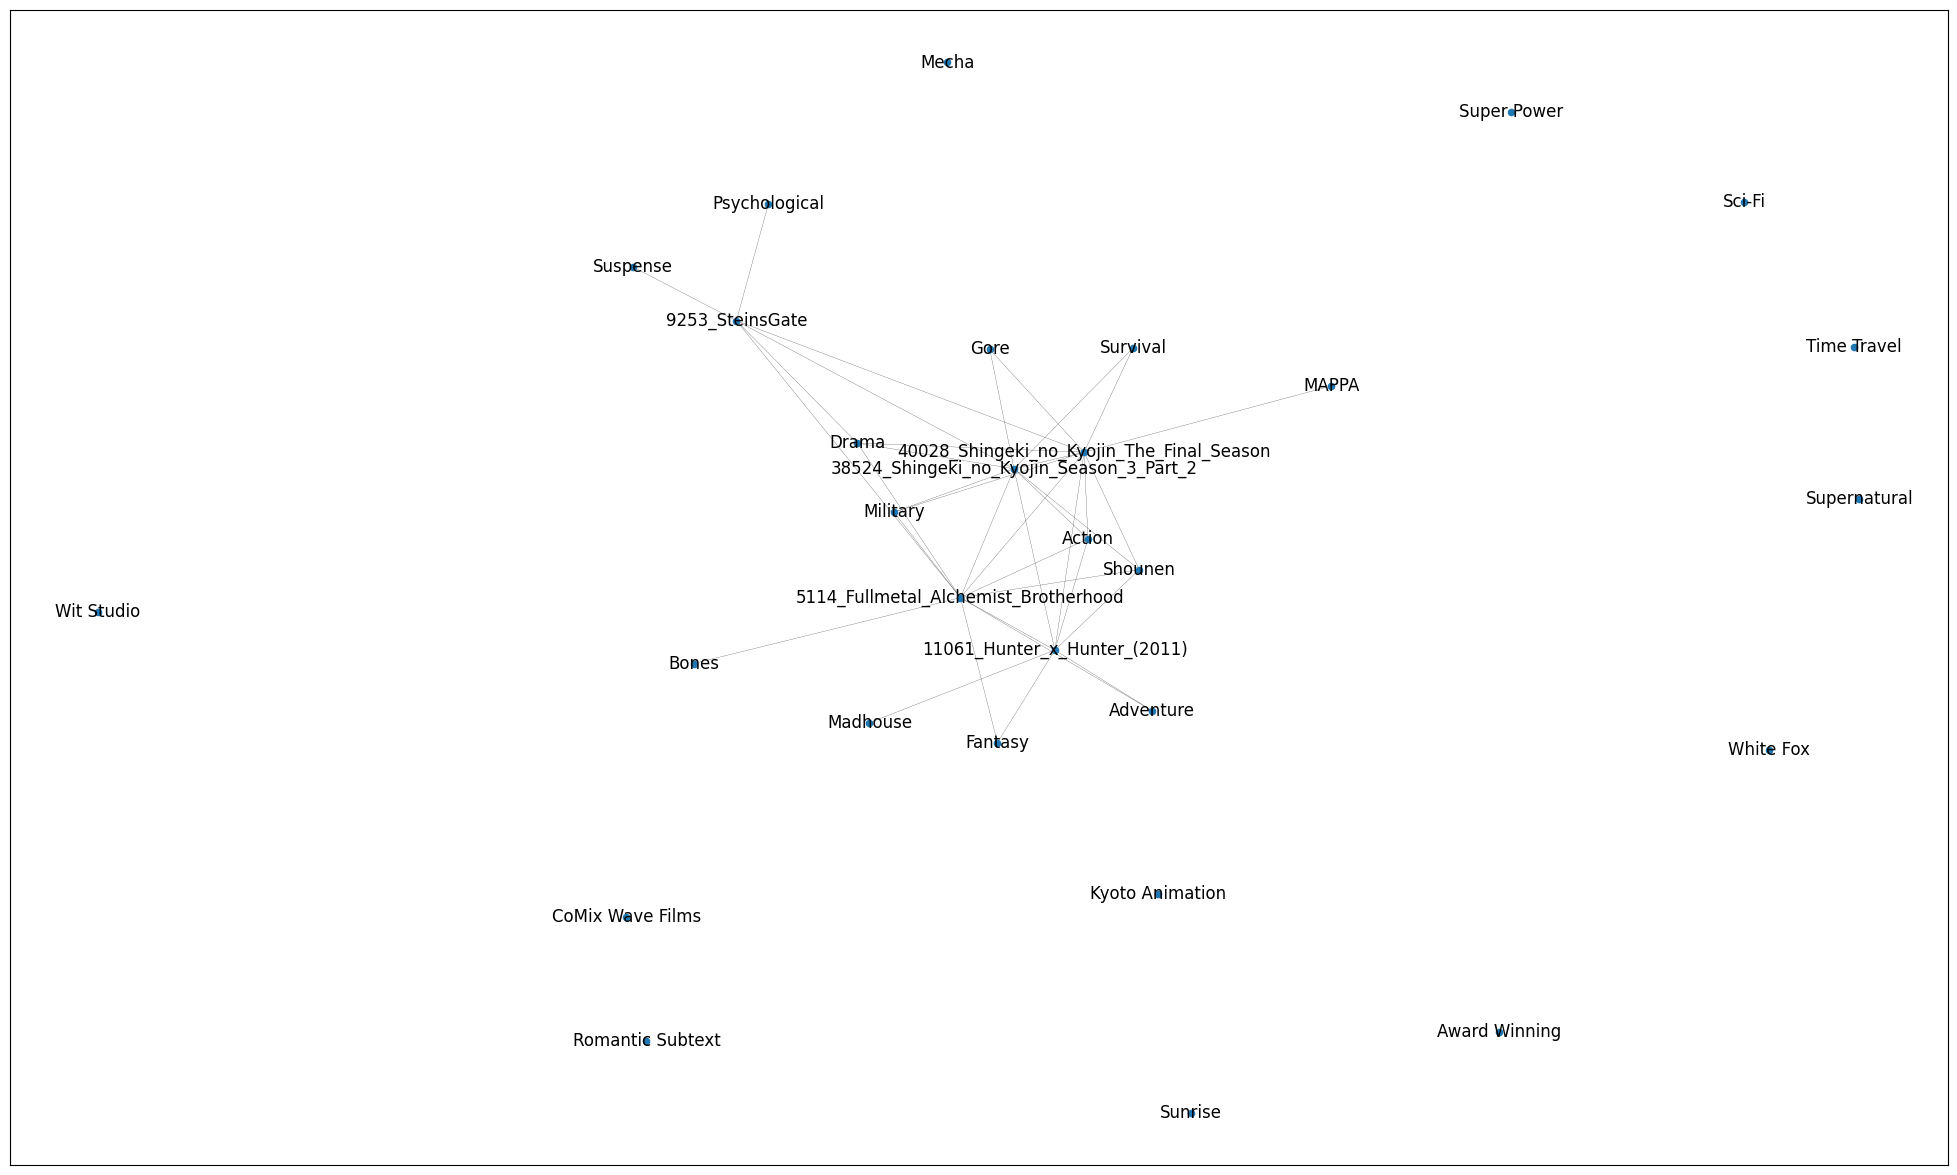

In [96]:
plot_options = {"node_size": 20, "with_labels": True, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1219)
fig, ax = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

#### Dataframes to Collections to load data into ArangoDB Manually
- We will define different node collections for different dataframes. 
- While we can use the networkX arangoDB library to do this, I think it is better if we define our own separate collections and build edges between them manually(for the practice)
- This will load the data into the ArangoDB as well. 

In [97]:
def build_collection(collection_name, dataframe, db):
    if not db.has_collection(collection_name):
        db.create_collection(collection_name)
    else:
        db.delete_collection(collection_name)
        db.create_collection(collection_name)

    collection = db.collection(collection_name)

    nodes = dataframe.to_dict(orient='records')
    collection.insert_many(nodes, overwrite=True)

def build_edge_list(edge_list_name, from_type, to_type, edge_df, db, predefined=False):
    if not db.has_collection(edge_list_name):
        db.create_collection(edge_list_name, edge=True)
    else:
        db.delete_collection(edge_list_name)
        db.create_collection(edge_list_name, edge=True)

    edge_collection = db.collection(edge_list_name)

    if predefined: 
        edge_collection.insert_many(edge_df, overwrite=True)
        return

    edge_df = edge_df.rename(columns={'_key_x': '_from', '_key_y': '_to'})
    # edge_df.iloc(1)
    edges = []
    for _, row in edge_df.iterrows():
        edge = {
            '_from': f'{from_type}/{row["_from"]}',
            '_to': f'{to_type}/{row["_to"]}'
        }
        edges.append(edge)
    edge_collection.insert_many(edges, overwrite=True)

graph_name = "anime_graph"
if db.has_graph(graph_name):
    db.delete_graph(graph_name)


build_collection("studios", studios_dataframe, db)
build_collection("themes", themes_dataframe, db)
build_collection("demographics", demographics_dataframe, db)
build_collection("genres", genre_dataframe, db)
build_collection("anime", anime, db)

build_edge_list("genres_edge_list", "anime", "genres", genres_edge_list, db)
build_edge_list("studios_edge_list", "anime", "studios", studios_edge_list, db)
build_edge_list("themes_edge_list", "anime", "themes", themes_edge_list, db)
build_edge_list("demographics_edge_list", "anime", "demographics", demographics_edge_list, db)
build_edge_list("similarity_edge_list", "anime", "anime", similarity_edges, db, predefined=True)

edge_definitions = [
    {
        "edge_collection": "genres_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["genres"]
    },
    {
        "edge_collection": "studios_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["studios"]
    },
    {
        "edge_collection": "themes_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["themes"]
    },
    {
        "edge_collection": "demographics_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["demographics"]
    },
    {
        "edge_collection": "similarity_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["anime"]
    }
]

vertex_collections = ["anime", "studios", "demographics", "themes", "genres"]

## Build the graph with the relations. 
graph = None
if not db.has_graph(graph_name):
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)
else:
    db.delete_graph(graph_name)
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)



Having loaded our data into Arango, we can check the schema to see if we got what we wanted.

In [98]:
# print([len(genre_dataframe), len(anime), len(themes_dataframe), len(demographics_dataframe), len(studios_dataframe)])
import pprint 

anime_graph = ArangoGraph(db)

pprint.pp(anime_graph.schema)

{'Graph Schema': [{'graph_name': 'anime_graph',
                   'edge_definitions': [{'edge_collection': 'demographics_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['demographics']},
                                        {'edge_collection': 'genres_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['genres']},
                                        {'edge_collection': 'similarity_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections': ['anime']},
                                        {'edge_collection': 'studios_edge_list',
                                         'from_vertex_collections': ['anime'],
                                         'to_vertex_collections

### ArangoDB && NetworkX
- Here we work to load the graph into a networkX object. Because of how the edges are drawn up in the graph, we define it as a `MultiDiGraph`
- Further we also implement the use of arango views. A view in the classical sense is just another query. They could be persisted in which case we have materialised views. The benefit of all this is that it acts as a caching step. This allows for faster query processing, because if the view is materialised and similar query is posed then the query does not need to run. The view can just be read out. This 

In [99]:
G_adb = nxadb.MultiDiGraph(
    name=graph_name,
    db=db,
    use_arango_views=True
)

[16:26:36 +0300] [INFO]: Graph 'anime_graph' exists.
[16:26:36 +0300] [INFO]: Default node type set to 'anime'


#### Playing around with NetworkX
- We can use some NetworkX algorithms to manipulate the graph. 
- For instance, here we use the page rank algorithm to check the similairty of anime

In [100]:
nx.config.backends.arangodb.use_gpu = True
nx.pagerank(G)
nx.betweenness_centrality(G)

pagerank_scores = nx.pagerank(G, alpha=0.9, weight="similarity")

top_anime = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)

print("Top anime based on pagerank: ")
for anime, score in top_anime:
    print(f"\t{anime} -> {score: .4f}")

Top anime based on pagerank: 
	5114_Fullmetal_Alchemist_Brotherhood ->  0.1331
	40028_Shingeki_no_Kyojin_The_Final_Season ->  0.1326
	38524_Shingeki_no_Kyojin_Season_3_Part_2 ->  0.1184
	11061_Hunter_x_Hunter_(2011) ->  0.0987
	9253_SteinsGate ->  0.0796
	Drama ->  0.0495
	Action ->  0.0487
	Shounen ->  0.0487
	Military ->  0.0376
	Adventure ->  0.0272
	Fantasy ->  0.0272
	Gore ->  0.0267
	Survival ->  0.0267
	Suspense ->  0.0172
	Psychological ->  0.0172
	Madhouse ->  0.0163
	Bones ->  0.0161
	MAPPA ->  0.0161
	Award Winning ->  0.0052
	Sci-Fi ->  0.0052
	Supernatural ->  0.0052
	Mecha ->  0.0052
	Romantic Subtext ->  0.0052
	Super Power ->  0.0052
	Time Travel ->  0.0052
	CoMix Wave Films ->  0.0052
	Kyoto Animation ->  0.0052
	Sunrise ->  0.0052
	White Fox ->  0.0052
	Wit Studio ->  0.0052


In [101]:
print(G_adb)

MultiDiGraph named 'anime_graph' with 30 nodes and 46 edges


## Building the Agentic App with LangChain & LangGraph

In [102]:
anime_graph = ArangoGraph(db)
anime_graph.schema

{'Graph Schema': [{'graph_name': 'anime_graph',
   'edge_definitions': [{'edge_collection': 'demographics_edge_list',
     'from_vertex_collections': ['anime'],
     'to_vertex_collections': ['demographics']},
    {'edge_collection': 'genres_edge_list',
     'from_vertex_collections': ['anime'],
     'to_vertex_collections': ['genres']},
    {'edge_collection': 'similarity_edge_list',
     'from_vertex_collections': ['anime'],
     'to_vertex_collections': ['anime']},
    {'edge_collection': 'studios_edge_list',
     'from_vertex_collections': ['anime'],
     'to_vertex_collections': ['studios']},
    {'edge_collection': 'themes_edge_list',
     'from_vertex_collections': ['anime'],
     'to_vertex_collections': ['themes']}]}],
 'Collection Schema': [{'collection_name': 'themes',
   'collection_type': 'document',
   'document_properties': [{'name': '_key', 'type': 'str'},
    {'name': '_id', 'type': 'str'},
    {'name': '_rev', 'type': 'str'},
    {'name': 'themes', 'type': 'str'},
   

As a basic test, we use the tool that was in the template document to accept a text string and generate  an aql query, execute it and return a response. 

We ask the agent to **Suggest an anime  with military themes**. In the graph, we have FullMetal Alchemist: Brotherhood and Attack on Titan. 

In [103]:
llm = ChatOpenAI(
    temperature=0, 
    model_name="Qwen2.5-72B-Instruct", 
    openai_api_key=sambanova_key,
    base_url="https://api.sambanova.ai/v1"
)

In [104]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=anime_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    prompt = f"""
    I have a graph in ArangoDb with the following schema {anime_graph.schema}. 
    
    I want to pose queries that will recommend anime based on the similarity edges, genres, themes, studios, demographics, start dtae, end date, rating and status of the show. 
    
    Pay attention to the attributes in the anime collection and prioritise using them in answering queries where possible.
    
    If the query does not request for anime with a similar genre, demographic, theme or studio, use the similarity_edge_list collection first to answer the query. 

    If the query is only asking for an anime with a specific genre, a specific theme, from a specific studio or for a specific demographic, form a query that uses the breadth first search originating from the genre, theme, demographic, or studio.

    If this query has no results, then use genre, theme, demographic and studio in that order.
    
    If there are no results, restructure the query so that the query returns the title field of an anime. 

    Generate an AQL query to answer the following query: {query}

    Based on the result, formulate a response as a structured message
    """
    
    # query_result = chain.invoke(prompt)

    final_result = chain.invoke(prompt)
    return str(final_result["result"])

# text_to_aql_to_text("Give me an anime that's has military themes")

In [105]:


similarity_prompt_template = PromptTemplate(
    template="""
    I have a graph in ArangoDb with the following schema: {schema}. 

    You are an anime recommendation bot. Within this graph, you will focus only on the similarity_edge_list to render recommendations.

    When a query asks you for an anime similar to another, you will create an AQL query that will search for anime up to the 2nd degree of separation.

    Ensure that the result returns only the title of the anime. 

    Generate an AQL query to answer the following query: {input_query}

    Based on the result, formulate a response as a structured message with the format: 

    {{
        "recommendations": results_of_query
    }}

    where results_of_query are the results of the query.
    """,
    input_variables=["schema", "input_query"]
    )

@tool
def similarity_query_gen(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.

    This tool focuses solely on using similarity indices to build queries
    """

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=anime_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    chain.return_aql_result = True
    chain.max_aql_generation_attempts = 5
    
    if not query:
        raise ValueError("Query cannot be empty!")

    # Format the prompt with necessary inputs
    formatted_prompt = similarity_prompt_template.format(
        schema=anime_graph.schema,  # Ensure anime_graph.schema exists
        input_query=query
    )
    
    # Invoke the LLM with structured input
    final_result = chain.invoke({"query": formatted_prompt})

    if isinstance(final_result, dict):
        if "aql_result" in final_result:  # If output is in chat format
            results = {'recommendations': final_result['aql_result']}
            return results

    return final_result  # Fallback in case of unexpected output

In [106]:
similarity_query_gen("What anime is similar to FullMetal Alchemist: Brotherhood")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH anime, similarity_edge_list
FOR v, e IN 1..2 OUTBOUND 'anime/5114_Fullmetal_Alchemist_Brotherhood' similarity_edge_list
    FILTER v._id != 'anime/5114_Fullmetal_Alchemist_Brotherhood'
    RETURN DISTINCT v.title

AQL Result:
['Shingeki no Kyojin: The Final Season', 'Steins;Gate', 'Shingeki no Kyojin Season 3 Part 2', 'Hunter x Hunter (2011)']

> Finished chain.


{'recommendations': ['Shingeki no Kyojin: The Final Season',
  'Steins;Gate',
  'Shingeki no Kyojin Season 3 Part 2',
  'Hunter x Hunter (2011)']}

In [107]:
genre_theme_prompt_template = PromptTemplate(
    template="""
    I have a graph in ArangoDb with the following schema: {schema}. 

    You are an anime recommendation bot. Within this graph, you will focus only on the genre, theme, genre_edge_list, theme_edge_list to render recommendations.

    Do NOT use the similarity_edge_list. 

    When a query asks you for an anime similar to another, you will create an AQL query that will search for anime that is connected to a similar genre or a theme.

    Ensure that the result returns only the title of the anime. 

    Generate an AQL query to answer the following query: {input_query}

    Based on the result, formulate a response as a structured message with the format: 

    {{
        "recommendations": results_of_query
    }}

    where results_of_query are the results of the query.
    """,
    input_variables=["schema", "input_query"]
    )

@tool
def genre_theme_query_gen(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.

    This tool focuses solely on using similarity indices to build queries
    """

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=anime_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    chain.return_aql_result = True
    chain.max_aql_generation_attempts = 5
    
    if not query:
        raise ValueError("Query cannot be empty!")

    # Format the prompt with necessary inputs
    formatted_prompt = genre_theme_prompt_template.format(
        schema=anime_graph.schema,  # Ensure anime_graph.schema exists
        input_query=query
    )
    
    # Invoke the LLM with structured input
    final_result = chain.invoke({"query": formatted_prompt})

    if isinstance(final_result, dict):
        if "aql_result" in final_result:  # If output is in chat format
            results = {'recommendations': final_result['aql_result']}
            return results

    return final_result  # Fallback in case of unexpected output

We see that it does in fact return these 2 anime. But it is a simple query. We go further to build a smarter app than this. 

In [108]:
genre_theme_query_gen("What anime is similar to FullMetal Alchemist: Brotherhood")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH anime, genres, themes, genres_edge_list, themes_edge_list
FOR a IN anime
    FILTER a.title == "Fullmetal Alchemist: Brotherhood"
    FOR g IN genres_edge_list
        FILTER g._from == a._id
        FOR ga IN anime
            FILTER ga._id != a._id
            FOR gg IN genres_edge_list
                FILTER gg._from == ga._id && gg._to == g._to
                RETURN ga.title
    FOR t IN themes_edge_list
        FILTER t._from == a._id
        FOR ta IN anime
            FILTER ta._id != a._id
            FOR tt IN themes_edge_list
                FILTER tt._from == ta._id && tt._to == t._to
                RETURN ta.title

AQL Query Execution Error: 
syntax error, unexpected FOR declaration, expecting end of query string near 'FOR t IN themes_edge_list
      ...' at position 12:5

AQL Query (2):
WITH anime, genres, themes, genres_edge_list, themes_edge_list
FOR a IN anime
    FILTER a.title == "Fullmetal Alchemist: 

ValueError: 
                Maximum amount of AQL Query Generation attempts reached.
                Unable to execute the AQL Query due to the following error:
                syntax error, unexpected FOR declaration, expecting end of query string near 'FOR t IN themes_edge_list
      ...' at position 12:5
            

In [113]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(
        temperature=0, 
        model_name="Qwen2.5-72B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1"
    )


    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

In [114]:
text_to_nx_algorithm_to_text("Find me the most popular anime")

1) Generating NetworkX code


[16:27:38 +0300] [WARNING]: nxadb.ArangoNodeView is currently EXPERIMENTAL


----------
import networkx as nx

# Assuming G_adb is already defined and loaded with the schema provided

# Step 1: Identify the 'anime' nodes and their 'members' attribute
anime_nodes = {node: G_adb.nodes[node]['members'] for node in G_adb.nodes if G_adb.nodes[node].get('type') == 'anime'}

# Step 2: Find the anime with the highest number of members
most_popular_anime = max(anime_nodes, key=anime_nodes.get)

# Step 3: Retrieve the title of the most popular anime
most_popular_anime_title = G_adb.nodes[most_popular_anime]['title']

# Final result
FINAL_RESULT = most_popular_anime_title
----------

2) Executing NetworkX code
EXEC ERROR: max() arg is an empty sequence


'EXEC ERROR: max() arg is an empty sequence'

In [ ]:
from langchain_core.prompts import PromptTemplate

tools = [similarity_query_gen, genre_theme_query_gen]
repetition = 3
agent_scratchpad = ""

recommender_llm = ChatOpenAI(
        temperature=0, 
        model_name="Meta-Llama-3.1-8B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1",
        respose_format="joson"
    )

react_agent_prompt_template = f"""
You are an anime recommendation bot.  
You have access to a graph database persisted in ArangoDB.  
You can utilize the following tools:  

- **text_to_aql_to_text**: Converts an input prompt into an AQL query and translates the result back into natural language.  
- **similarity_query_gen**: Generates recommendations using only the similarity edges in the database.  
- **genre_theme_query_gen**: Generates recommendations using genre and theme information from the database.  

### **Instructions**  
Follow the format below when processing a query:  

1. **Question:** The input question you must answer.  
2. **Thought:** Your reasoning about how to proceed.  
3. **Action:** The action to take (must be one of {[*tools]}).  
4. **Action Input:** The input to the selected action.  
5. **Observation:** The result of the action.  
6. **Repeat** the Thought/Action/Action Input/Observation steps up to {repetition} times if needed.  
7. **Thought:** I now know the final answer.  
8. **Final Answer:** The final answer to the original input query.  

### **Example Flow**  

Question: What anime are similar to Attack on Titan?
Thought: I should use the similarity edges in the database to find related anime.
Action: similarity_query_gen
Action Input: "Attack on Titan"
Observation: Found similar anime: [Death Note, Code Geass, Vinland Saga].
Thought: I now know the final answer.
Final Answer: If you enjoyed Attack on Titan, you may also like Death Note, Code Geass, and Vinland Saga.

### **Begin!**  
Question: {input}  
Thought: {agent_scratchpad}
"""

# Ensure the PromptTemplate is correctly defined
prompt = PromptTemplate(
    template=react_agent_prompt_template,
    input_variables=["input", "agent_scratchpad"]
)

app = create_react_agent(recommender_llm, tools)  # Create the ReAct agent
agent_executor = AgentExecutor(agent=app, tools=tools, verbose=True)

def query_graph(query):
    if not query:
        raise ValueError('Query cannot be empty!')
    
    formatted_prompt = react_agent_prompt_template.format(
        input=query,
        agent_scratchpad=agent_scratchpad
    )
    
    response = agent_executor.invoke({"input": query})

    # if isinstance(response, dict) and "messages" in response:
    #     return response["messages"][-1]["content"]
    
    return response  # Fallback for other formats

    

/home/w3ndo/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3519: UserWarning: WARNING! respose_format is not default parameter.
                respose_format was transferred to model_kwargs.
                Please confirm that respose_format is what you intended.
  if await self.run_code(code, result, async_=asy):


In [ ]:
# Query list

query_graph("Recommend anime similar to FullMetal Alchemist: Brotherhood")

# queries = [
#     # " I really liked the anime Fullmetal Alchemist: Brotherhood, what other animes like this would I enjoy?",
#     # "Find me an anime with a military theme that has finished airing.",
#     # "Give me an anime that started before 2012 with themes of gore and survival.",
#     # "Recommend safe for work animes for my nephew who is 12 years old.",
#     # "Give me an anime based on a manga with themes of Romance that is still airing with a score less than 7.5",
#     # "Give me an anime with the episode runtime of about 30-40 minutes with for the Shounen demographic.",
#     # "I want a funny or carefree anime to watch",
#     # "What is a depressing anime I can watch"
#     ]


# for query in queries:
#     query_graph(query)



> Entering new AgentExecutor chain...


InvalidUpdateError: Must write to at least one of ['messages']

In [ ]:
import gradio as gr

gr.Interface(fn=query_graph, inputs="text", outputs="text").launch(share=True)